In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [38]:
df = pd.read_csv("auto-mpg.csv")
dataset = pd.read_csv("auto-mpg.csv", skipinitialspace=True)
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [39]:
origin = dataset.pop('origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset = dataset.reset_index(drop=True)

dataset = dataset.apply(pd.to_numeric, errors='coerce')
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504,12.0,70,NaN,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693,11.5,70,NaN,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436,11.0,70,NaN,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433,12.0,70,NaN,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449,10.5,70,NaN,1.0,0.0,0.0


In [40]:
dataset = dataset.fillna(dataset.mean())
dataset=dataset.drop('car name',axis=1)
null_values = dataset.isnull().sum()
print("Null values present in the dataset after filling NaNs:\n", null_values)

if dataset.isnull().values.any():
    raise ValueError("Dataset still contains NaN values after filling")

Null values present in the dataset after filling NaNs:
 mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
USA             0
Europe          0
Japan           0
dtype: int64


In [41]:
# Split the data into training and test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('mpg')
test_labels = test_dataset.pop('mpg')
train_stats = train_dataset.describe().transpose()

In [42]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset).astype(np.float32)
normed_test_data = norm(test_dataset).astype(np.float32)

In [43]:
# Model1
def build_model_1():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model_1 = build_model_1()
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                640       
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4865 (19.00 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Model2
def build_model_2():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model_2 = build_model_2()
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 128)               1280      
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 11649 (45.50 KB)
Trainable params: 11649 (45.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Model 3
def build_model_3():
    model = keras.Sequential([
        layers.Dense(32, activation='tanh', input_shape=[len(train_dataset.keys())]),
        layers.Dense(32, activation='tanh'),
        layers.Dense(16, activation='tanh'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model_3 = build_model_3()
model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 32)                320       
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 16)                528       
                                                                 
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1921 (7.50 KB)
Trainable params: 1921 (7.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Define a callback to print a dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
EPOCHS = 1000

In [47]:
example_batch = normed_train_data[:10]

In [48]:
print("\nPredictions from Model 1:")
example_result_1 = model_1.predict(example_batch)
print(example_result_1)


Predictions from Model 1:
1/1 [==============================] - 0s 76ms/step
[[ 0.2843826 ]
 [-0.11473553]
 [ 0.2316159 ]
 [-1.0788041 ]
 [-0.12079703]
 [-0.67069626]
 [-0.56584436]
 [-0.08126891]
 [ 0.09869063]
 [-0.14356056]]


In [49]:
print("\nPredictions from Model 2:")
example_result_2 = model_2.predict(example_batch)
print(example_result_2)


Predictions from Model 2:


1/1 [==============================] - 0s 95ms/step
[[-0.04292025]
 [-0.08815104]
 [-0.034123  ]
 [-0.09254232]
 [-0.05790251]
 [-0.30491933]
 [ 0.05845679]
 [-0.11187743]
 [-0.100553  ]
 [-0.03851935]]


In [50]:
print("\nPredictions from Model 3:")
example_result_3 = model_3.predict(example_batch)
print(example_result_3)


Predictions from Model 3:


1/1 [==============================] - 0s 115ms/step
[[ 1.0060792 ]
 [ 0.2382293 ]
 [ 0.84738517]
 [-0.5073901 ]
 [ 0.7713431 ]
 [-0.17133194]
 [-0.8883523 ]
 [ 0.38180798]
 [ 1.06832   ]
 [ 0.0562219 ]]



...........................................................

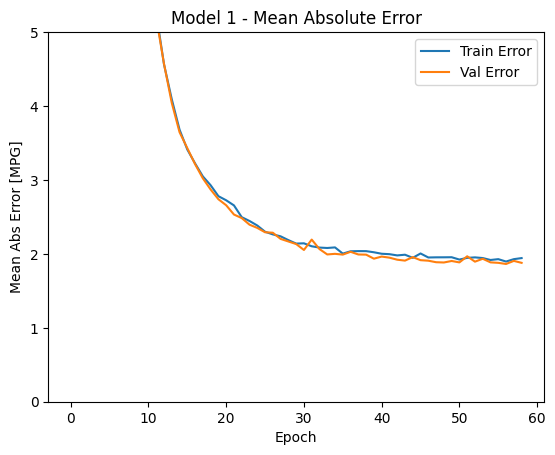

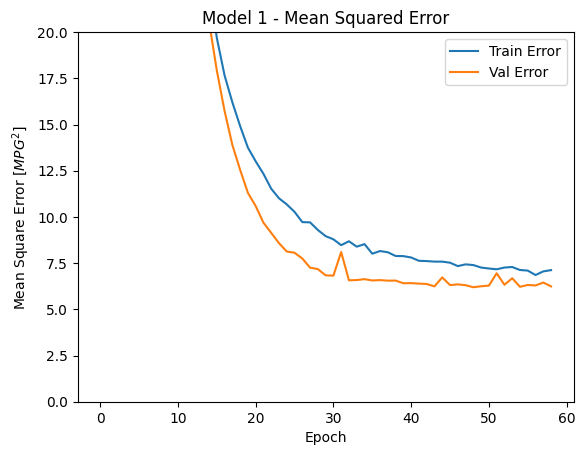

In [51]:
# Train and evaluate Model 1
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_1 = model_1.fit(normed_train_data, train_labels, epochs=1000,
                        validation_split=0.2, verbose=0,
                        callbacks=[early_stop, PrintDot()])
plot_history(history_1, "Model 1")

In [52]:
loss_1, mae_1, mse_1 = model_1.evaluate(normed_test_data, test_labels, verbose=0)
print("Model 1 - Testing set Mean Abs Error: {:5.2f} MPG".format(mae_1))

Model 1 - Testing set Mean Abs Error:  1.96 MPG



Training Model 2

....................................................................................................
........................

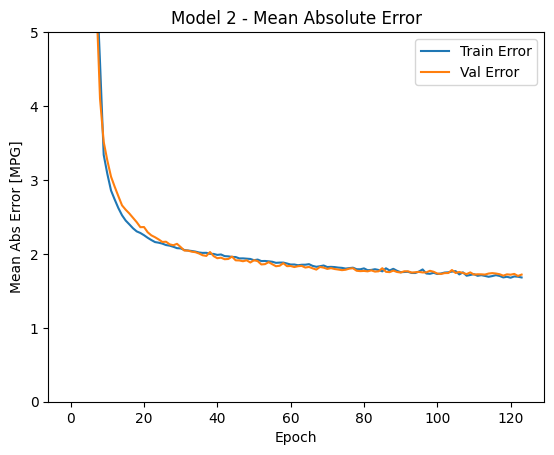

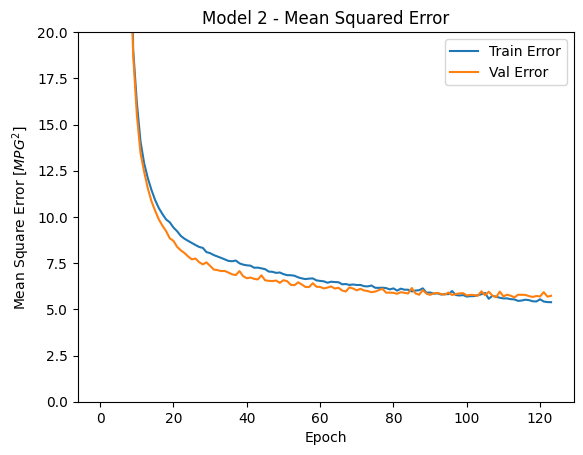

In [53]:
# Train and evaluate Model 2
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_2 = model_2.fit(normed_train_data, train_labels, epochs=1000,
                        validation_split=0.2, verbose=0,
                        callbacks=[early_stop, PrintDot()])
plot_history(history_2, "Model 2")

In [54]:
loss_2, mae_2, mse_2 = model_2.evaluate(normed_test_data, test_labels, verbose=0)
print("Model 2 - Testing set Mean Abs Error: {:5.2f} MPG".format(mae_2))

Model 2 - Testing set Mean Abs Error:  1.87 MPG



Training Model 3

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.........................................

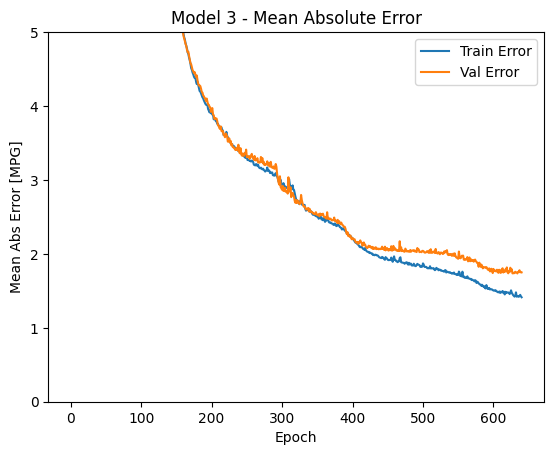

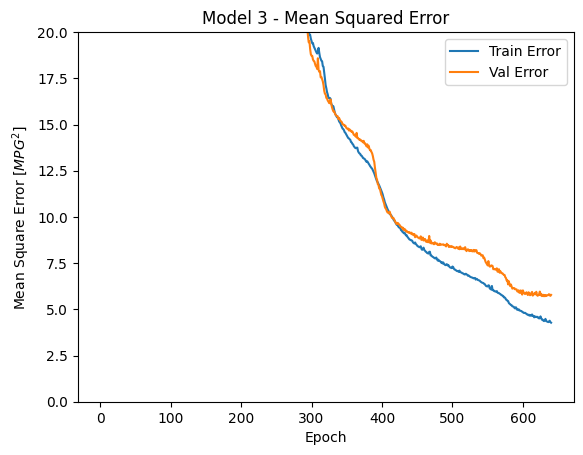

In [55]:
# Train and evaluate Model 3
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history_3 = model_3.fit(normed_train_data, train_labels, epochs=1000,
                        validation_split=0.2, verbose=0,
                        callbacks=[early_stop, PrintDot()])
plot_history(history_3, "Model 3")

In [56]:
loss_3, mae_3, mse_3 = model_3.evaluate(normed_test_data, test_labels, verbose=0)
print("Model 3 - Testing set Mean Abs Error: {:5.2f} MPG".format(mae_3))

Model 3 - Testing set Mean Abs Error:  2.14 MPG


In [57]:
def plot_predictions(model, model_name):
    test_predictions = model.predict(normed_test_data).flatten()

    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0, plt.xlim()[1]])
    plt.ylim([0, plt.ylim()[1]])
    plt.plot([-100, 100], [-100, 100])
    plt.title(f'{model_name} - Predictions vs. True Values')
    plt.show()

3/3 [==============================] - 0s 3ms/step


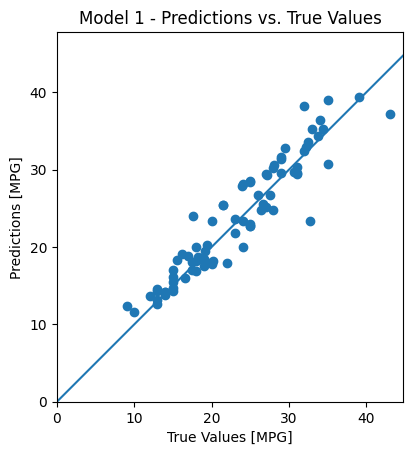

In [58]:
plot_predictions(model_1, "Model 1")

3/3 [==============================] - 0s 4ms/step


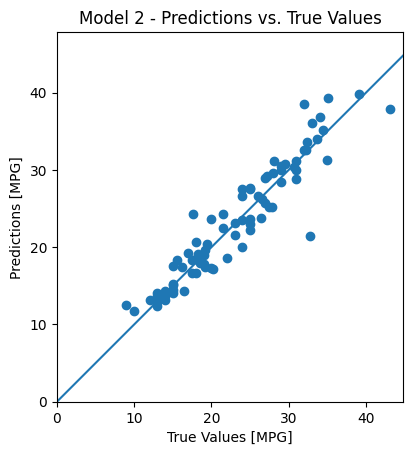

In [59]:
plot_predictions(model_2, "Model 2")

3/3 [==============================] - 0s 3ms/step


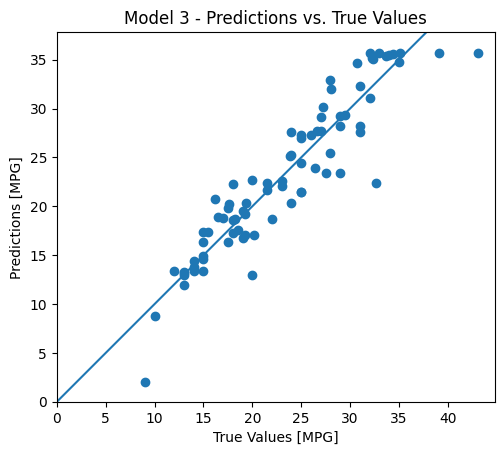

In [60]:
plot_predictions(model_3, "Model 3")

In [61]:
def plot_residuals(true_values, predictions, model_name):
    residuals = true_values - predictions
    plt.figure()
    plt.scatter(true_values, residuals)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

In [62]:
def plot_prediction_distribution(true_values, predictions, model_name):
    plt.figure()
    sns.histplot(true_values, color='blue', label='True Values', kde=True)
    sns.histplot(predictions, color='orange', label='Predicted Values', kde=True)
    plt.xlabel('MPG')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Prediction Distribution')
    plt.legend()
    plt.show()

3/3 [==============================] - 0s 11ms/step


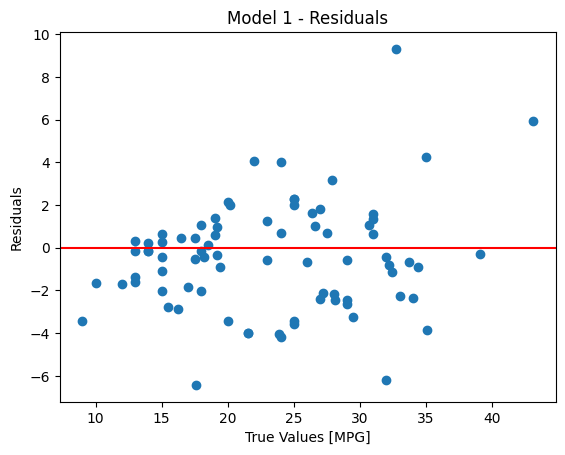

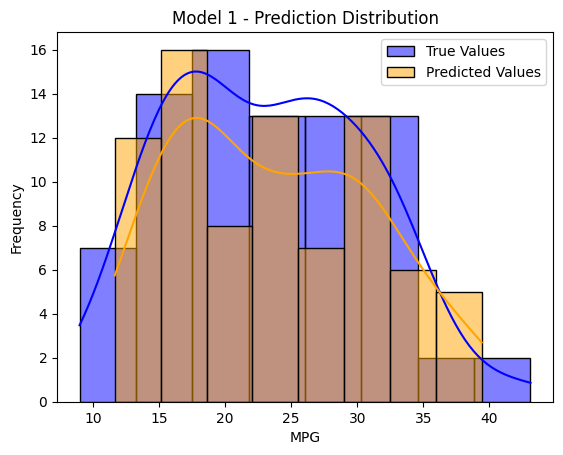

In [63]:
predictions_1 = model_1.predict(normed_test_data).flatten()
plot_residuals(test_labels, predictions_1, "Model 1")
plot_prediction_distribution(test_labels, predictions_1, "Model 1")

3/3 [==============================] - 0s 4ms/step


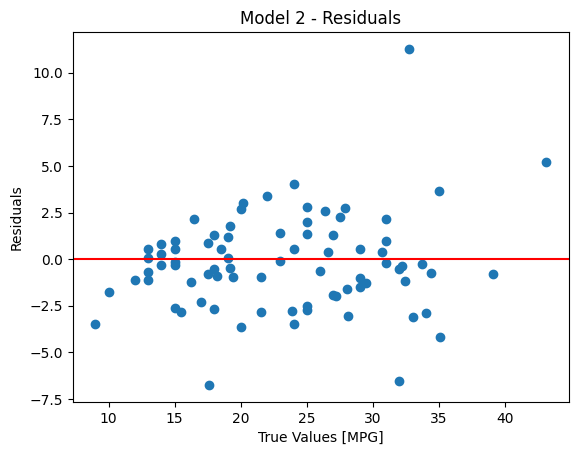

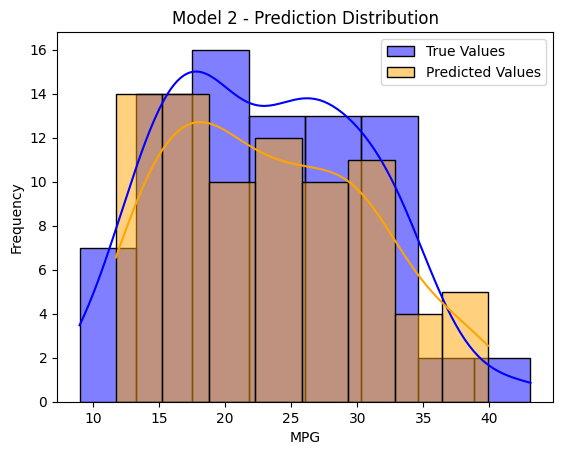

In [64]:
predictions_2 = model_2.predict(normed_test_data).flatten()
plot_residuals(test_labels, predictions_2, "Model 2")
plot_prediction_distribution(test_labels, predictions_2, "Model 2")

3/3 [==============================] - 0s 3ms/step


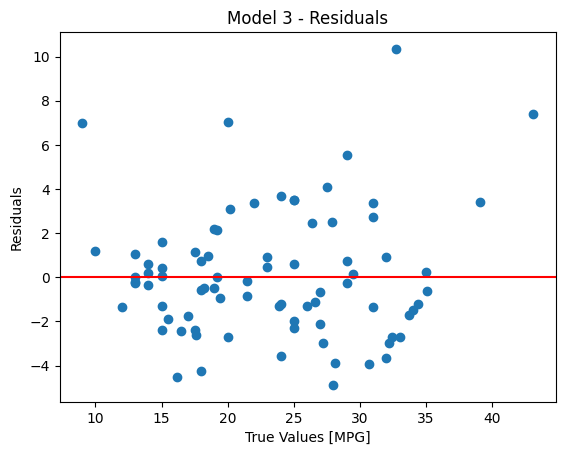

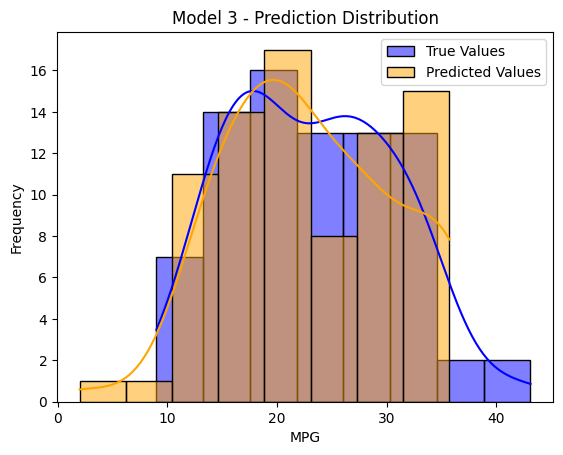

In [65]:
predictions_3 = model_3.predict(normed_test_data).flatten()
plot_residuals(test_labels, predictions_3, "Model 3")
plot_prediction_distribution(test_labels, predictions_3, "Model 3")